#### Importing Libraries

In [2]:
#!/usr/bin/env python
# coding: utf-8
print('--------------------------------------------------')
print('RF')
print('--------------------------------------------------')
print('Importing Libraries')
print('--------------------------------------------------')

# Makes sure we see all columns

from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.datasets import load_iris
# Loading Scikits random fo
#rest classifier
import sklearn
#import lime
from sklearn.preprocessing import OneHotEncoder

# from utils import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#from sklearn.metrics import auc_score
from sklearn.multiclass import OneVsRestClassifier
from collections import Counter
from sklearn.preprocessing import label_binarize
#loading pandas
import pandas as pd
#Loading numpy
import numpy as np
# Setting random seed
import time

import shap
from scipy.special import softmax
np.random.seed(0)
import matplotlib.pyplot as plt
import random

from sklearn.metrics import f1_score, accuracy_score
#from interpret.blackbox import LimeTabular
from interpret import show
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)
shap.initjs()

print('Defining Function')
print('--------------------------------------------------')

def oversample(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='minority')
    # Convert to numpy and oversample
    x_np = X_train.to_numpy()
    y_np = y_train.to_numpy()
    x_np, y_np = oversample.fit_resample(x_np, y_np)
    
    # Convert back to pandas
    x_over = pd.DataFrame(x_np, columns=X_train.columns)
    y_over = pd.Series(y_np)
    return x_over, y_over
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the feature
s, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

def ACC(x,y,w,z):
    Acc = (x+y)/(x+w+z+y)
    return Acc

def PRECISION(x,w):
    Precision = x/(x+w)
    return Precision
def RECALL(x,z):
    Recall = x/(x+z)
    return Recall
def F1(Recall, Precision):
    F1 = 2 * Recall * Precision / (Recall + Precision)
    return F1
def BACC(x,y,w,z):
    BACC =(x/(x+z)+ y/(y+w))*0.5
    return BACC
def MCC(x,y,w,z):
    MCC = (y*x-z*w)/(((x+w)*(x+z)*(y+w)*(y+z))**.5)
    return MCC
def AUC_ROC(y_test_bin,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_avg = 0
    counting = 0
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     # plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
      #print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))
        auc_avg += auc(fpr[i], tpr[i])
        counting = i+1
    return auc_avg/counting


--------------------------------------------------
RF
--------------------------------------------------
Importing Libraries
--------------------------------------------------


/home/oarreche@ads.iu.edu/anaconda3/envs/HITL/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defining Function
--------------------------------------------------


#### Loading Dataset

In [3]:

print('Selecting Column Features')
print('--------------------------------------------------')

# Choose features to import + label

req_cols = ['FLOW_DURATION_MILLISECONDS','FIRST_SWITCHED',
            'TOTAL_FLOWS_EXP','TCP_WIN_MSS_IN','LAST_SWITCHED',
            'TCP_WIN_MAX_IN','TCP_WIN_MIN_IN','TCP_WIN_MIN_OUT',
           'PROTOCOL','PROTOCOL_MAP','TCP_WIN_MAX_OUT','TCP_FLAGS',
            'TCP_WIN_SCALE_OUT','TCP_WIN_SCALE_IN','SRC_TOS',
            'DST_TOS','FLOW_ID','L4_SRC_PORT','L4_DST_PORT',
           'MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','TOTAL_PKTS_EXP',
           'TOTAL_BYTES_EXP','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS',
            'ALERT']

#Load Databases from csv file
address = '/home/oarreche@ads.iu.edu/HITL/sensor/sensor_db'
print('Loading Database')
print('--------------------------------------------------')

#Denial of Service
df0 = pd.read_csv (address + '/dos-03-15-2022-15-44-32.csv', usecols=req_cols)
df1 = pd.read_csv (address + '/dos-03-16-2022-13-45-18.csv', usecols=req_cols)
df2 = pd.read_csv (address + '/dos-03-17-2022-16-22-53.csv', usecols=req_cols)
df3 = pd.read_csv (address + '/dos-03-18-2022-19-27-05.csv', usecols=req_cols)
df4 = pd.read_csv (address + '/dos-03-19-2022-20-01-53.csv', usecols=req_cols)
df5 = pd.read_csv (address + '/dos-03-20-2022-14-27-54.csv', usecols=req_cols)


#Malware
#df6 = pd.read_csv ('sensor_db/malware-03-25-2022-17-57-07.csv', usecols=req_cols)

#Normal
df7 = pd.read_csv  (address + '/normal-03-15-2022-15-43-44.csv', usecols=req_cols)
df8 = pd.read_csv  (address + '/normal-03-16-2022-13-44-27.csv', usecols=req_cols)
df9 = pd.read_csv  (address + '/normal-03-17-2022-16-21-30.csv', usecols=req_cols)
df10 = pd.read_csv (address + '/normal-03-18-2022-19-17-31.csv', usecols=req_cols)
df11 = pd.read_csv (address + '/normal-03-18-2022-19-25-48.csv', usecols=req_cols)
df12 = pd.read_csv (address + '/normal-03-19-2022-20-01-16.csv', usecols=req_cols)


#PortScanning
df14 = pd.read_csv  (address + '/portscanning-03-15-2022-15-44-06.csv', usecols=req_cols)
df15 = pd.read_csv  (address + '/portscanning-03-16-2022-13-44-50.csv', usecols=req_cols)
df16 = pd.read_csv  (address + '/portscanning-03-17-2022-16-22-53.csv', usecols=req_cols)
df17 = pd.read_csv  (address + '/portscanning-03-18-2022-19-27-05.csv', usecols=req_cols)
df18 = pd.read_csv  (address + '/portscanning-03-19-2022-20-01-45.csv', usecols=req_cols)
df19 = pd.read_csv  (address + '/portscanning-03-20-2022-14-27-49.csv', usecols=req_cols)


frames = [df0, df1, df2, df3, df4, df5, df7, df8, df9, df10, df11, df12, df14, df15, df16, df17, df18, df19]

#concat data frames
df = pd.concat(frames,ignore_index=True)

# shuffle the DataFrame rows
df = df.sample(frac = 0.001)

Selecting Column Features
--------------------------------------------------
Loading Database
--------------------------------------------------


#### Pre Processing

In [4]:
# Factorize and extract the labels from the column PROTOCAL MAP
u, label = pd.factorize(df['PROTOCOL_MAP']) 

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'PROTOCOL_MAP' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['PROTOCOL_MAP']]).toarray())

#merge one-hot encoded columns back with original DataFrame
df = df.join(encoder_df)

temp =list(label.values)
req_cols.remove('PROTOCOL_MAP')
df.drop('PROTOCOL_MAP', axis=1, inplace=True)

req_cols = req_cols + temp
df.columns = req_cols

# assign alert column to y
y = df.pop('ALERT')

# join alert back to df
df = df.assign( ALERT = y) 

#Fill NaN with 0s
df = df.fillna(0)

# Normalize database
print('---------------------------------------------------------------------------------')
print('Normalizing database')
print('---------------------------------------------------------------------------------')
print('')

# make a df copy
df_max_scaled = df.copy()

# assign alert column to y
y = df_max_scaled.pop('ALERT')

#Normalize operation
for col in df_max_scaled.columns:
    t = abs(df_max_scaled[col].max())
    df_max_scaled[col] = df_max_scaled[col]/t
df_max_scaled
#assign df copy to df
df = df_max_scaled.assign( ALERT = y)
#Fill NaN with 0s
df = df.fillna(0)

# Separate features and labels

print('---------------------------------------------------------------------------------')
print('Counting labels')
print('---------------------------------------------------------------------------------')
print('')

y = df.pop('ALERT')
X = df

# count class distribution 
counter = Counter(y)

df = X.assign( ALERT = y)

#Remove duplicates
df = df.drop_duplicates()

y = df.pop('ALERT')
X = df

df = df.assign( ALERT = y)
# summarize class distribution
counter = Counter(y)

# ## Train and Test split

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, train_size=0.80)
df = X.assign( ALERT = y)

# Balance Dataset

print('---------------------------------------------------------------------------------')
print('Balance Datasets')
print('---------------------------------------------------------------------------------')
print('')
counter = Counter(labels_train)
print(counter)

# call balance operation until all labels have the same size
counter_list = list(counter.values())
for i in range(1,len(counter_list)):
    if counter_list[i-1] != counter_list[i]:
        train, labels_train = oversample(train, labels_train)


counter = Counter(labels_train)
print(counter)


# # After OverSampling training dataset

train = train.assign( ALERT = labels_train)

#Drop ALert column from train
train.pop('ALERT')
# ## Training the model


---------------------------------------------------------------------------------
Normalizing database
---------------------------------------------------------------------------------

---------------------------------------------------------------------------------
Counting labels
---------------------------------------------------------------------------------

---------------------------------------------------------------------------------
Balance Datasets
---------------------------------------------------------------------------------

Counter({'None': 14843, 'Denial of Service': 5078, 'Port Scanning': 3367})
Counter({'None': 14843, 'Denial of Service': 14843, 'Port Scanning': 14843})


0                     None
1                     None
2                     None
3        Denial of Service
4                     None
               ...        
44524    Denial of Service
44525    Denial of Service
44526    Denial of Service
44527    Denial of Service
44528    Denial of Service
Name: ALERT, Length: 44529, dtype: object

#### Training model and getting metrics

In [5]:
print('Defining the model')
print('--------------------------------------------------')
rf = RandomForestClassifier(max_depth = 10,  n_estimators = 50, min_samples_split = 2, n_jobs = -1)
#------------------------------------------------------------------------------

print('Training the model')
print('------------------------------------------------------------------------------')
#START TIMER MODEL
start = time.time()
model = rf.fit(train, labels_train)
#END TIMER MODEL
end = time.time()
print('ELAPSE TIME MODEL: ',(end - start)/60, 'min')

print('------------------------------------------------------------------------------')
#------------------------------------------------------------------------------
# # Oversampling and balancing test data
counter = Counter(labels_test)
print(counter)
counter_list = list(counter.values())
for i in range(1,len(counter_list)):
    if counter_list[i-1] != counter_list[i]:
        test, labels_test = oversample(test, labels_test)

counter = Counter(labels_test)

#joining features and label
test = test.assign(ALERT = labels_test)

#Randomize df order
test = test.sample(frac = 1)

#Drop label column
labels_test = test.pop('ALERT')

#------------------------------------------------------------------------------
#START TIMER PREDICTION
start = time.time()
preds = rf.predict(test)
#END TIMER PREDICTION
end = time.time()
print('ELAPSE TIME PREDICTION: ',(end - start)/60, 'min')

print('------------------------------------------------------------------------------')
#------------------------------------------------------------------------------
pred_label = preds
confusion_matrix = pd.crosstab(labels_test,  pred_label , rownames=['Actual ALERT'], colnames = ['Predicted ALERT'])
print(confusion_matrix)

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)

TP_total = sum(TP)
TN_total = sum(TN)
FP_total = sum(FP)
FN_total = sum(FN)

TP_total = np.array(TP_total,dtype=np.float64)
TN_total = np.array(TN_total,dtype=np.float64)
FP_total = np.array(FP_total,dtype=np.float64)
FN_total = np.array(FN_total,dtype=np.float64)

Acc = ACC(TP_total,TN_total, FP_total, FN_total)
Precision = PRECISION(TP_total, FP_total)
Recall = RECALL(TP_total, FN_total)
F1 = F1(Recall,Precision)
BACC = BACC(TP_total,TN_total, FP_total, FN_total)
MCC = MCC(TP_total,TN_total, FP_total, FN_total)

print('Accuracy: ', Acc)
print('Precision: ', Precision )
print('Recall: ', Recall )
print('F1: ', F1 )
print('BACC: ', BACC)
print('MCC: ', MCC)
y_test = labels_test
y_score = rf.predict_proba(test)
#binarize the output
y_test_bin = label_binarize(y_test,classes = [0,1,2])
n_classes = y_test_bin.shape[1]
tmp, y_labels = pd.factorize(labels_test)
label = y_labels
print('AUC_ROC total: ', roc_auc_score(labels_test, rf.predict_proba(test), multi_class='ovr'))
for i in range(0,len(TP)):
    Acc = ACC(TP[i],TN[i], FP[i], FN[i])
    print('Accuracy: ', label[i] ,' - ' , Acc)

Defining the model
--------------------------------------------------
Training the model
------------------------------------------------------------------------------
ELAPSE TIME MODEL:  0.004380865891774496 min
------------------------------------------------------------------------------
Counter({'None': 3695, 'Denial of Service': 1291, 'Port Scanning': 836})
ELAPSE TIME PREDICTION:  0.0017992496490478516 min
------------------------------------------------------------------------------
Predicted ALERT    Denial of Service  None  Port Scanning
Actual ALERT                                             
Denial of Service               3695     0              0
None                               0  3692              3
Port Scanning                      0     0           3695
Accuracy:  0.9998195760036085
Precision:  0.9997293640054127
Recall:  0.9997293640054127
F1:  0.9997293640054127
BACC:  0.9997970230040596
MCC:  0.9995940460081191
AUC_ROC total:  0.9999989501716042
Accuracy:  Port 

### Generating Graphs

##### Summary Bar Plot Global

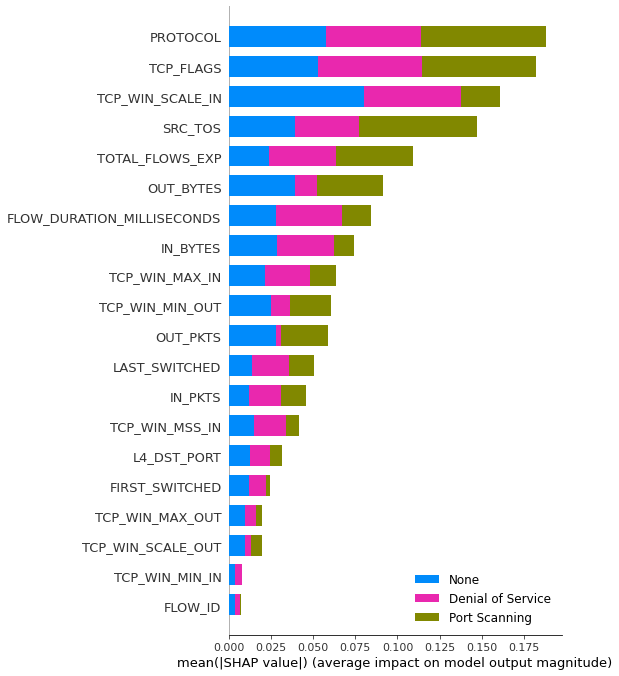

In [6]:
# # ------------------- GLOBAL ----------------------------
plt.clf()
# ## Summary Bar Plot Global
explainer = shap.TreeExplainer(rf)
start_index = 0
end_index = 500
shap_values = explainer.shap_values(test[start_index:end_index])
shap_obj = explainer(test[start_index:end_index])
shap.summary_plot(shap_values = shap_values,
                  features = test[start_index:end_index],
                 class_names=[y_labels[0],y_labels[1],y_labels[2]],show=False)



##### Summary Dot Plot (Global)

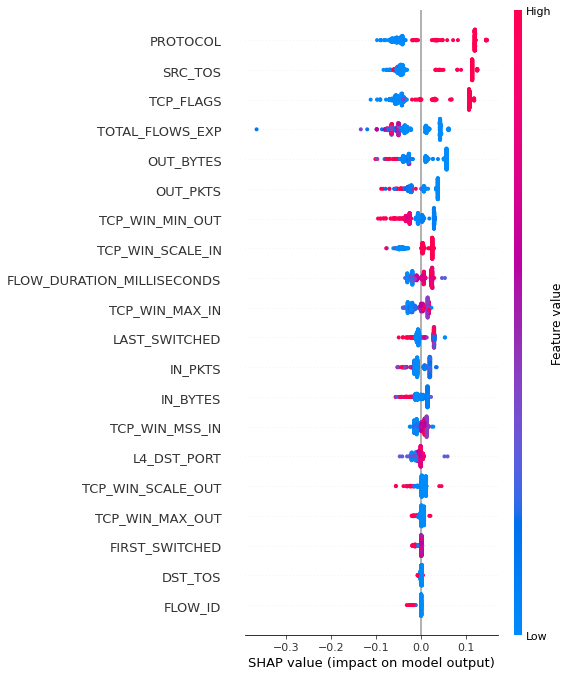

In [7]:
# plt.savefig('RF_Shap_Summary_global.png')
plt.clf()
# ## Summary Dot Plot (Global)
shap.summary_plot(shap_values = np.take(shap_obj.values,0,axis=-1),
                  features = test[start_index:end_index],show=False)
# plt.savefig('RF_Shap_Summary_Beeswarms.png')
# plt.clf()
